In [217]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
import re

In [218]:
path = 'eren_rgb.jpg'
path1 = 'file.irm'
path2 = 'reconstiued1.jpg'
num_rows = 2
num_colors = 32
num_blocs = 16
image = np.array(Image.open(path))

In [219]:
def details(path):
    img = Image.open(path)
    size = img.size
    format = img.format
    mode = img.mode
    resolution = img.info.get('dpi')
    definition = size[0] * size[1]
    definition2 = size
    if resolution is not None:
        size = (size[0]/ resolution[0], size[1] / resolution[1])
    else:
        size = (0, 0)  # or any default resolution you want to use
    
    poids = os.path.getsize(path) / (1000.0)  # Convert to kilobytes
    
    if mode == 'RGB':
        trsc = definition * 3 * img.bits
    else:
        trsc = definition * 1 * img.bits
    
    trsc /= (1024 * 8)
    
    taux_compression = 100 * (1 - (poids/trsc))
        
    return size, format, mode, resolution, definition, definition2, poids, trsc, taux_compression

In [220]:
def display_image_with_palette(image, color_palette, palette_indices, num_rows):
    num_colors = len(color_palette)
    num_cols = num_colors // num_rows

    image_with_palette = color_palette[palette_indices]

    plt.figure(figsize=(30, 15))
    for i, color in enumerate(color_palette):
        plt.subplot(num_rows, num_cols, i + 1)
        color_patch = np.zeros((100, 100, 3), dtype=np.uint8)
        color_patch[:, :] = color
        plt.imshow(color_patch)
        plt.title(f'Couleur {i+1}')
        plt.axis('off')
    plt.suptitle('Palette de couleurs', fontsize=16)
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(30, 15))
    fig.subplots_adjust(wspace=0.01)

    axs[0].imshow(image)
    axs[0].set_title('Image originale')
    axs[0].axis('off')

    axs[1].imshow(image_with_palette)
    axs[1].set_title(f'Image avec la palette de {num_colors} couleurs')
    axs[1].axis('off')

    fig.tight_layout()

    plt.show()

In [221]:
def plot_images(reconstructed_image, image1, num_colors):
    fig, axs = plt.subplots(1, 2, figsize=(30, 15))
    fig.subplots_adjust(wspace=0.01)

    axs[0].imshow(reconstructed_image)
    axs[0].set_title('Image reconstruite')
    axs[0].axis('off')

    axs[1].imshow(image1)
    axs[1].set_title(f'Image avec la palette de {num_colors} couleurs (median-cut)')
    axs[1].axis('off')

    fig.tight_layout()

    plt.show()

In [222]:
def MSE(image_d_origine, image_traitee):
    # Get the dimensions of the images
    L, C = np.array(image_d_origine).shape[:2]  # Assuming it's a 2D image, getting rows and columns
    image_traitee = np.array(image_traitee).reshape(np.array(image_d_origine).shape)
    # Convert the images to NumPy arrays
    origine = np.array(image_d_origine)
    traitee = np.array(image_traitee)

    # Calculate the sum of squared differences
    somme_differences_carrees = np.sum((origine - traitee) ** 2)

    # Calculate (1 / (L * C)) * somme
    resultat = (1 / (L * C)) * somme_differences_carrees

    return resultat

In [223]:
def taux_compression(img_path, compressed_file_path):
    img = Image.open(img_path)
    
    if img.mode == 'RGB':
        pixel_size = 3  # Nombre de canaux de couleur (RGB)
    else:
        pixel_size = 1  # Pour d'autres modes de couleur
    
    if img.bits == 8:  # Taille en bits par pixel
        pixel_bits = 8
    else:
        pixel_bits = 16  # Peut être ajusté selon les besoins
    
    img_data_size = img.size[0] * img.size[1] * pixel_size * pixel_bits  # Taille en bits de l'image
    
    # Lecture des données compressées à partir du fichier .irm
    with open(compressed_file_path, 'rb') as f:
        compressed_data = f.read()
    
    compressed_data_size = len(compressed_data) * 8  # Taille des données compressées en bits
    
    compression_ratio = 1 - (img_data_size / compressed_data_size)  # Ratio de compression
    
    return compression_ratio

In [224]:
def rgb_to_ycrcb(rgb_image):
    rgb_image = np.array(rgb_image)
    ycrcb_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2YCrCb)
    return ycrcb_image

In [225]:
def ycrcb_to_rgb(ycrcb_image):
    rgb_image = cv2.cvtColor(np.array(ycrcb_image), cv2.COLOR_YCrCb2RGB)
    # Convert numpy array to PIL Image
    rgb_image_pil = Image.fromarray(rgb_image)
    # Save the PIL Image
    return rgb_image_pil

In [226]:
def kmeans_clustering_palette(image, num_colors):
    # Convertir l'image en un tableau 2D de pixels
    pixels = np.reshape(image, (-1, 3))  # (nombre de pixels, 3 canaux de couleur)

    # Appliquer l'algorithme de k-means clustering
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)

    # Obtenir les centres des clusters (couleurs dominantes)
    color_palette = kmeans.cluster_centers_.astype(int)

    # Associer chaque pixel à l'indice de couleur dans la palette
    labels = kmeans.predict(pixels)

    # Reformater les indices des couleurs dans la palette selon la forme de l'image originale
    palette_indices = np.reshape(labels, np.array(image).shape[:2])

    return color_palette, palette_indices

In [227]:
def median_cut_palette(image, num_colors):
    # Convertir l'image en un tableau 2D de pixels
    pixels = np.reshape(image, (-1, 3))

    # Initialiser la liste des cubes de couleur avec le cube contenant tous les pixels
    cubes = [pixels]

    # Répéter jusqu'à ce que le nombre de cubes atteigne le nombre de couleurs souhaité
    while len(cubes) < num_colors:
        # Sélectionner le cube le plus grand
        largest_cube_index = np.argmax([cube.shape[0] for cube in cubes])
        largest_cube = cubes.pop(largest_cube_index)

        # Trouver l'axe dominant pour diviser le cube
        axis = np.argmax(np.max(largest_cube, axis=0) - np.min(largest_cube, axis=0))

        # Trier les pixels du cube le long de l'axe dominant
        sorted_cube = largest_cube[largest_cube[:, axis].argsort()]

        # Diviser le cube en deux parties égales
        split_index = len(sorted_cube) // 2
        cube1 = sorted_cube[:split_index]
        cube2 = sorted_cube[split_index:]

        # Ajouter les deux nouveaux cubes à la liste
        cubes.append(cube1)
        cubes.append(cube2)

    # Calculer les couleurs moyennes pour chaque cube
    color_palette = [np.mean(cube, axis=0) for cube in cubes]
    color_palette = np.array(color_palette).astype(np.uint8)

    # Calculer les indices des couleurs dans la palette pour chaque pixel de l'image
    palette_indices = np.zeros(len(pixels), dtype=int)
    for i, pixel in enumerate(pixels):
        distances = np.linalg.norm(color_palette - pixel, axis=1)
        palette_indices[i] = np.argmin(distances)

    palette_indices = np.reshape(palette_indices, np.array(image).shape[:2])

    return color_palette, palette_indices

In [228]:
def octree_palette(image, num_colors):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
        
    img_rgb = image.convert("RGB")
    img_with_palette = img_rgb.quantize(colors=num_colors, method=Image.FASTOCTREE)
    palette = img_with_palette.getpalette()[:num_colors * 3]
    palette = np.array(palette).reshape(-1, 3)
    indices = np.array(img_with_palette)

    # Retourner la palette de couleurs et leurs indices
    return palette, indices

In [229]:
def inverse_kmeans_clustering_palette(color_palette, palette_indices):
    # Récupérer les dimensions de l'image à partir des indices de palette
    height, width = palette_indices.shape

    # Initialiser une image vide avec les dimensions récupérées
    reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Remplir l'image reconstruite avec les couleurs de la palette
    for i in range(height):
        for j in range(width):
            color_index = palette_indices[i, j]
            reconstructed_image[i, j] = color_palette[color_index]

    return reconstructed_image

In [230]:
def inverse_median_cut_palette(color_palette, palette_indices):
    # Récupérer les dimensions de l'image à partir des indices de palette
    height, width = palette_indices.shape

    # Initialiser une image vide avec les dimensions récupérées
    reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Remplir l'image reconstruite avec les couleurs de la palette
    for i in range(height):
        for j in range(width):
            color_index = palette_indices[i, j]
            reconstructed_image[i, j] = color_palette[color_index]
  
    return reconstructed_image

In [231]:
def inverse_octree_palette(color_palette, palette_indices):
    color_palette = color_palette.reshape(-1)
    color_palette = [(int(color_palette[i]), int(color_palette[i + 1]), int(color_palette[i + 2])) for i in range(0, len(color_palette), 3)]
    reconstructed_image = Image.new("RGB", (palette_indices.shape[1], palette_indices.shape[0]))
    reconstructed_image.putdata([color_palette[idx] for idx in palette_indices.flatten()])
  
    return reconstructed_image

In [232]:
def map_to_palette(image, color_palette):
    # Assurez-vous que l'image est sous forme de tableau numpy
    image = np.array(image)
    
    # Redimensionner les pixels en une matrice (nombre de pixels, 3 canaux de couleur)
    pixels = np.reshape(image, (-1, 3))  

    # Calculer la distance de chaque pixel à chaque couleur de la palette
    distances = np.linalg.norm(pixels[:, np.newaxis] - color_palette, axis=2)

    # Obtenir l'indice de la couleur la plus proche pour chaque pixel
    indices = np.argmin(distances, axis=1)

    # Reformater les indices des couleurs selon la forme de l'image originale
    mapped_indices = np.reshape(indices, image.shape[:2])

    return np.array(mapped_indices)

In [233]:
def inverse_map_to_palette(mapped_indices, color_palette):
    # Obtenir les dimensions de l'image reconstruite
    height, width = mapped_indices.shape

    # Créer une image vide
    reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Pour chaque pixel, assigner la couleur correspondante de la palette
    for i in range(height):
        for j in range(width):
            color_index = mapped_indices[i, j]
            reconstructed_image[i, j] = color_palette[color_index]

    return Image.fromarray(reconstructed_image)

In [234]:
def subdivision(matrice, taille_blocs):
    # Dimensions de la matrice initiale
    lignes, colonnes = matrice.shape
    
    # Dimensions des blocs
    blocs_lignes, blocs_colonnes = (taille_blocs, taille_blocs)
    
    # Calcul des dimensions des blocs avec zéros ajoutés
    new_blocs_lignes = (lignes + blocs_lignes - 1) // blocs_lignes
    new_blocs_colonnes = (colonnes + blocs_colonnes - 1) // blocs_colonnes
    
    # Initialisation de la matrice des sous-matrices
    sous_matrices = np.zeros((new_blocs_lignes, new_blocs_colonnes, blocs_lignes, blocs_colonnes))
    
    # Remplissage de la matrice des sous-matrices
    for i in range(new_blocs_lignes):
        for j in range(new_blocs_colonnes):
            sous_matrices[i, j, :min(blocs_lignes, lignes - i*blocs_lignes), :min(blocs_colonnes, colonnes - j*blocs_colonnes)] = \
                matrice[i*blocs_lignes:(i+1)*blocs_lignes, j*blocs_colonnes:(j+1)*blocs_colonnes]
    
    # Convertir la matrice de sous-matrices en une liste de matrices 2D
    liste_matrices = []
    for i in range(new_blocs_lignes):
        for j in range(new_blocs_colonnes):
            liste_matrices.append(sous_matrices[i, j])
    
    return liste_matrices, (lignes, colonnes)

In [235]:
def reconstitution(liste_matrices, dimensions):# Récupération des dimensions de la matrice initiale
    lignes, colonnes = dimensions
    
    # Initialisation de la matrice résultante avec des zéros
    matrice_resultante = np.zeros((lignes, colonnes))
    
    # Dimensions des blocs
    taille_blocs = liste_matrices[0].shape
    
    # Nombre de blocs
    nb_blocs_lignes = (lignes + taille_blocs[0] - 1) // taille_blocs[0]
    nb_blocs_colonnes = (colonnes + taille_blocs[1] - 1) // taille_blocs[1]
    
    # Recombinaison des sous-matrices dans la matrice résultante
    for i in range(nb_blocs_lignes):
        for j in range(nb_blocs_colonnes):
            matrice_resultante[i*taille_blocs[0]:(i+1)*taille_blocs[0], j*taille_blocs[1]:(j+1)*taille_blocs[1]] = \
                liste_matrices[i*nb_blocs_colonnes + j][:min(taille_blocs[0], lignes - i*taille_blocs[0]), :min(taille_blocs[1], colonnes - j*taille_blocs[1])]
    
    return np.array(matrice_resultante, dtype=np.int64)

In [236]:
def sous_echantillonnage_4_2_0(image):
    # Sous-échantillonnage de l'image
    sub_image = image[::2, ::2]
    
    return sub_image

In [237]:
def sous_echantillonnage_4_2_2(image):
    # Sous-échantillonnage de l'image
    sub_image = image[::1, ::2]
    
    return sub_image

In [238]:
def sous_echantillonnage_4_4_4(image):
    # La fonction ne fait rien car il n'y a pas de sous-échantillonnage pour le 4:4:4
    return image.copy() 

In [239]:
def inverse_sous_echantillonnage_4_2_0(imSub):
    # Répétition des pixels pour restaurer la résolution horizontale
    H, W = imSub.shape
    res_h = np.repeat(imSub, 2, axis=1)
    
    # Répétition des pixels pour restaurer la résolution verticale
    res_v = np.repeat(res_h, 2, axis=0)
    
    return res_v

In [240]:
def inverse_sous_echantillonnage_4_4_4(imSub):
    # L'inverse du sous-échantillonnage 4:4:4 est simplement une copie de l'image d'entrée
    return imSub.copy()

In [241]:
def ligne_scan(matrice):
  shape = matrice.shape
  vecteur = matrice.flatten()
  return np.array(vecteur), shape

In [242]:
def colonne_scan(matrice):
    shape = matrice.shape
    vecteur = np.ravel(matrice, order = 'F')
    return np.array(vecteur), shape

In [243]:
def zigzag_scan(matrice):
  shape = matrice.shape
  vecteur = np.concatenate([np.diagonal(matrice[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1 - matrice.shape[0], matrice.shape[0])])
  return np.array(vecteur), shape

In [244]:
def inverse_ligne_scan(vecteur, shape):
  mat = np.array(vecteur).reshape((shape[0], shape[1]))
  return mat

In [245]:
def inverse_colonne_scan(vecteur, shape):
    mat = np.array(vecteur).reshape((shape[0], shape[1]))
    return mat.T

In [246]:
def inverse_zigzag_scan(vector, shape):
    rows, cols = shape
    mat = np.zeros((rows, cols))
    row, col = 0, 0
    direction = 1

    for i in range(rows * cols):
        mat[row][col] = vector[i]
        if direction == 1:
            if col == cols - 1:
                row += 1
                direction = -1
            elif row == 0:
                col += 1
                direction = -1
            else:
                row -= 1
                col += 1
        else:
            if row == rows - 1:
                col += 1
                direction = 1
            elif col == 0:
                row += 1
                direction = 1
            else:
                row += 1
                col -= 1

    return mat

In [247]:
def rle_encode(data):
    encoded_data = ""
    current_char = data[0]
    count = 1

    for i in range(1, len(data)):
        if data[i] == current_char:
            count += 1
        else:
            if count > 1:  # Ajout de cette condition
                encoded_data += str(current_char) + "_" + str(count) + "*"
            else:
                encoded_data += str(current_char) + "*"
            current_char = data[i]
            count = 1

    if count > 1:  # Ajout de cette condition
        encoded_data += str(current_char) + "_" + str(count)
    else:
        encoded_data += str(current_char)

    return encoded_data

In [248]:
def rle_decode(encoded_data):
    decoded_data = []
    encoded_data_split = encoded_data.split('*')

    for item in encoded_data_split:
        if "_" in item:
            char, count = item.split("_")
            char = float(char)
            if char.is_integer():
                char = int(char)
            decoded_data.extend([char] * int(count))
        else:
            char = float(item)
            if char.is_integer():
                char = int(char)
            decoded_data.append(char)

    return decoded_data

In [249]:
def ext_chr(chaine):
    occ = {c: chaine.count(c) for c in set(chaine)}
    return sorted(occ.items(), key=lambda x: x[1], reverse=True)

In [250]:
def huffman_dictionnary_code(node, binString=''):
    if isinstance(node, str):
        return {node: binString}
    (l, r) = node
    d = {}
    d.update(huffman_dictionnary_code(l, binString + '0'))
    d.update(huffman_dictionnary_code(r, binString + '1'))
    return d

In [251]:
def huffman_tree(chaine):
    nodes = ext_chr(chaine)
    
    while len(nodes) > 1:
        (key1, c1) = nodes.pop()
        (key2, c2) = nodes.pop()
        node = (key1, key2)
        nodes.append((node, c1 + c2))
        nodes.sort(key=lambda x: x[1], reverse=True)
        
    return nodes[0][0]

In [252]:
def encoding_huffman(string):
    nodes = huffman_tree(string)
    huffmanCode = huffman_dictionnary_code(nodes)
    
    compressed_string = ''
    for char in string:
        compressed_string += huffmanCode[char]
    return compressed_string, nodes

In [253]:
def decoding_huffman(compressed_string, huffman_tree):
    decoded_string = ''
    current_node = huffman_tree
    
    for bit in compressed_string:
        if bit == '0':
            current_node = current_node[0]
        else:
            current_node = current_node[1]
        
        if isinstance(current_node, str):
            decoded_string += current_node
            current_node = huffman_tree
    
    return decoded_string

In [254]:
def fusionner(strings_list):
    tailles = []
    string_fusionned = ""
    
    # Parcourir tous les éléments de la liste
    for string in strings_list:
        # Convertir chaque nombre en chaîne de caractères et l'ajouter à la chaîne fusionnée
        string_fusionned += string
        
        # Ajouter la taille de l'élément à la liste des tailles
        tailles.append(len(string))
    
    # Retourner la chaîne de caractères fusionnée et la liste des tailles
    return string_fusionned, tailles

In [255]:
def separer(string_fusionned, tailles):
    strings_list = []
    debut = 0
    
    # Parcourir toutes les tailles dans la liste
    for taille in tailles:
        # Extraire le sous-chaîne correspondant à la taille actuelle
        sous_chaine = string_fusionned[debut:debut+taille]
        
        # Convertir la sous-chaîne en nombre et l'ajouter à la liste des nombres
        strings_list.append(sous_chaine)
        
        # Mettre à jour la position de départ pour la prochaine sous-chaîne
        debut += taille
    
    # Retourner la liste des nombres
    return strings_list

In [256]:
def encoding_lzw(data):
    alphabet = ['0', '1']
    data_fused, taille = fusionner(data)  # Fusionner les chaînes de caractères
    encoded_data = []

    dictionary = {}  # Initialiser le dictionnaire avec les caractères de l'alphabet spécifié
    for i, char in enumerate(alphabet):
        dictionary[char] = i

    prefix = ''
    for char in data_fused:
        new_entry = prefix + char
        if new_entry in dictionary:
            prefix = new_entry
        else:
            encoded_data.append(dictionary[prefix])
            dictionary[new_entry] = len(dictionary)
            prefix = char

    if prefix:
        encoded_data.append(dictionary[prefix])

    return encoded_data, taille

In [257]:
def decoding_lzw(compressed_data, taille):
    alphabet = ['0', '1']
    result = []
    dictionary = {}
    current_code = len(alphabet)

    # Initialiser le dictionnaire avec les caractères de l'alphabet spécifié
    for i, char in enumerate(alphabet):
        dictionary[i] = char

    old_entry = dictionary[compressed_data[0]]
    result.append(old_entry)
    for new_entry in compressed_data[1:]:
        if new_entry in dictionary:
            entry = dictionary[new_entry]
        elif new_entry == current_code:
            entry = old_entry + old_entry[0]
        else:
            raise ValueError("Mauvaise séquence compressée")

        result.append(entry)

        # Utilisez le même dictionnaire pour la décompression
        dictionary[current_code] = old_entry + entry[0]
        current_code += 1
        old_entry = entry

    result = ''.join(result)
    result = separer(result, taille)
    
    return result

In [258]:
def intermediaire_compression(imageA, num_colorsA):
  ycrcb_imageA = rgb_to_ycrcb(imageA)
  color_paletteA, palette_indicesA = kmeans_clustering_palette(ycrcb_imageA, num_colorsA)
  mapped_indicesA = map_to_palette(ycrcb_imageA, color_paletteA)
  liste_blocsA, dimensions_originalesA = subdivision(mapped_indicesA, 16)
  compressed_textsA = []
  treesA = []
  
  for blocA in liste_blocsA:
    vecteur_comprimeA, shapeA = ligne_scan(blocA)
    chaineA = rle_encode(vecteur_comprimeA)
    compressed_textA, treeA = encoding_huffman(chaineA)
    compressed_textsA.append(compressed_textA)
    treesA.append(treeA)
    
  encoded_dataA, tailleA = encoding_lzw(compressed_textsA)
  return encoded_dataA, dimensions_originalesA, color_paletteA, palette_indicesA, shapeA, treesA, tailleA

In [259]:
def intermediaire_decompression(encoded_dataB, dimensions_originalesB, color_paletteB, palette_indicesB, shapeB, treesB, tailleB):
  decompressed_textB = decoding_lzw(encoded_dataB, tailleB)
  liste_blocsB = []
  
  for i in range(len(decompressed_textB)):
    encoded_stringB = decoding_huffman(decompressed_textB[i], treesB[i])
    vecteur_comprimeB = rle_decode(encoded_stringB)
    blocB = inverse_ligne_scan(vecteur_comprimeB, shapeB)
    liste_blocsB.append(blocB)
  
  mapped_indicesB = reconstitution(liste_blocsB, dimensions_originalesB)
  imageB = inverse_map_to_palette(mapped_indicesB, color_paletteB)
  reconstructed_imageB = inverse_kmeans_clustering_palette(color_paletteB, palette_indicesB)
  rgb_image = ycrcb_to_rgb(imageB)
  
  return rgb_image

In [260]:
def create_header(path, num_colors):
  image = Image.open(path)
  return intermediaire_compression(image, num_colors)[1:]

In [261]:
def data_irm(path, num_colors):
  image = Image.open(path)
  return intermediaire_compression(image, num_colors)[0]

In [262]:
def header_irm(path, num_colors):
    header = ""
    shapeT, color_palette, palette_indices, shapet, huffman_trT, taille = create_header(path, num_colors)
    header += f"taille: {taille}\n"
    header += f"huffman_trT: {huffman_trT}\n"
    header += f"shapeT: {shapeT}\n"
    header += f"shapet: {shapet}\n"
    header += f"color_palette: {list(map(list,list(color_palette)))}\n"
    header += f"palette_indices: {list(map(list,list(palette_indices)))}\n"
    return header

In [263]:
def compression_irm(path1, num_colors, path2):
    header = header_irm(path1, num_colors)
    data = data_irm(path1, num_colors)
    compressed_data = "\n".join(str(nombre) for nombre in data)
    with open(path2, 'w') as f:
        f.write(header)
        f.write(compressed_data)

In [264]:
def decompression_irm(path1, path2):
    with open(path1, 'r') as f:
        lines = f.readlines()
        numeric_lines = [line.strip() for line in lines if re.match(r'^\d+$', line.strip())]
        encoded_data = [int(nombre.strip()) for nombre in numeric_lines]
        taille = np.array(eval(lines[0].split(': ')[1]))
        huffman_trT = eval(lines[1].split(': ')[1])
        shapeT = eval(lines[2].split(': ')[1])
        shapet = eval(lines[3].split(': ')[1])
        color_palette = np.array(eval(lines[4].split(': ')[1]))
        palette_indices = np.array(eval(lines[5].split(': ')[1]))
    
    image = intermediaire_decompression(encoded_data, shapeT, color_palette, palette_indices, shapet, huffman_trT, taille)
    image.save(path2)
    return image

In [265]:
compression_irm(path, num_colors, path1)

/home/issa-sangare/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/issa-sangare/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [266]:
dataA = intermediaire_compression(image, num_colors)

/home/issa-sangare/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [267]:
dataB = intermediaire_decompression(dataA[0], dataA[1], dataA[2], dataA[3], dataA[4], dataA[5], dataA[6])

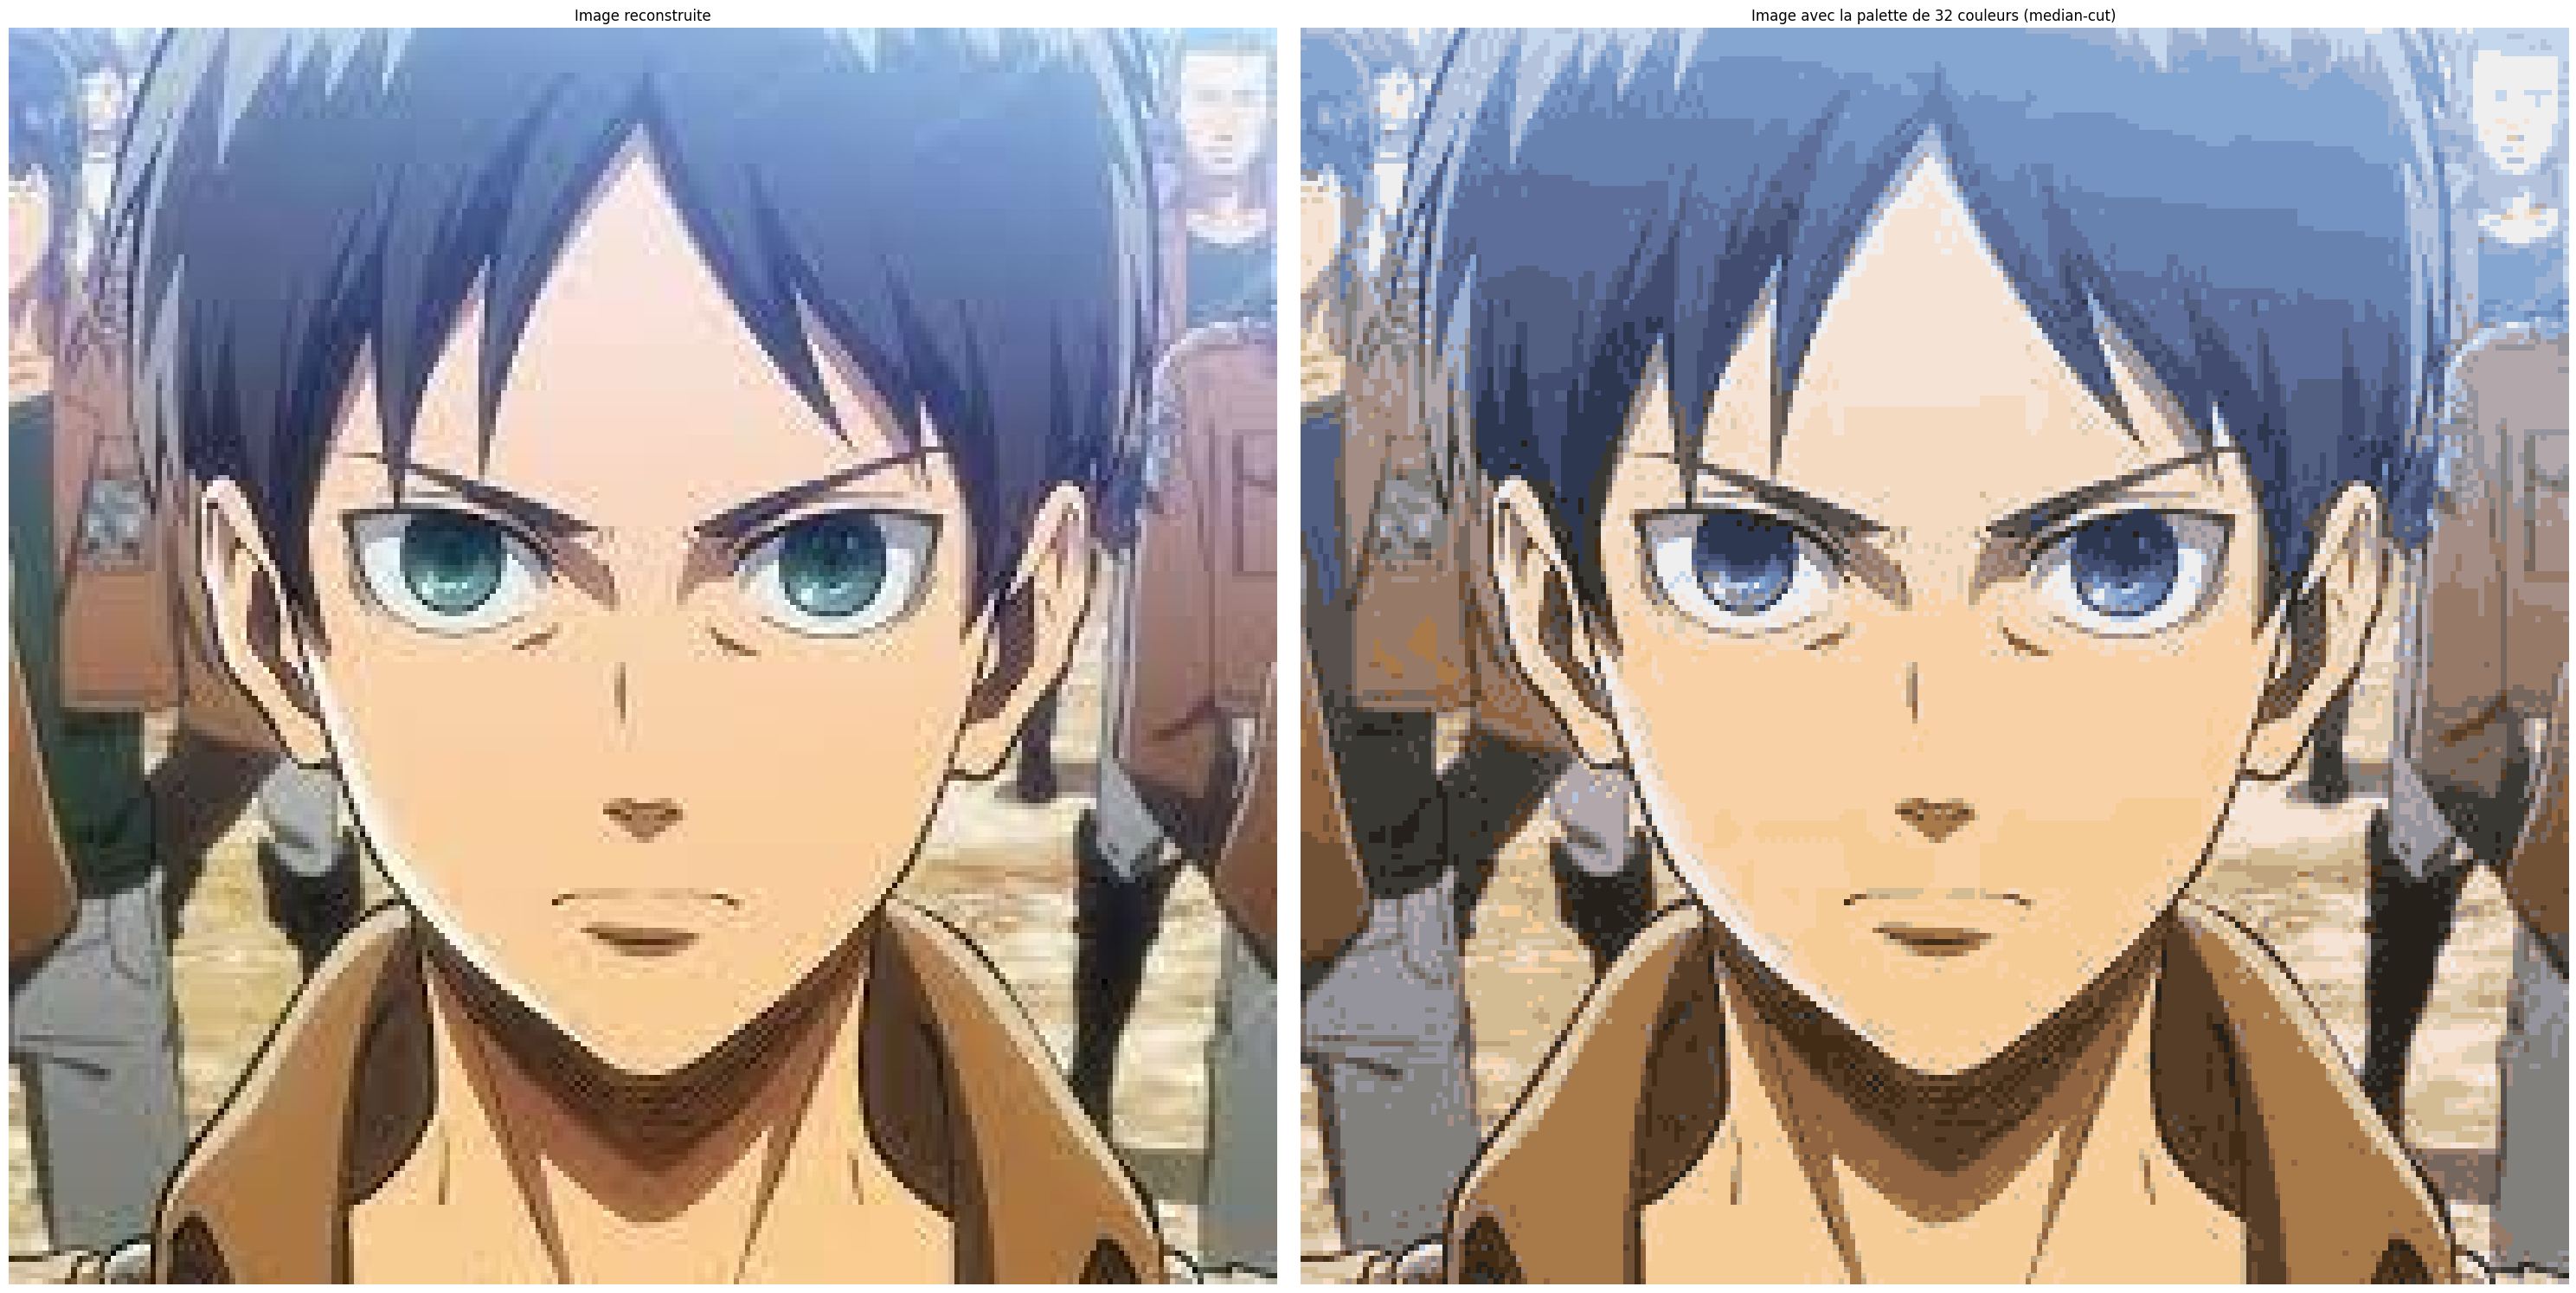

In [268]:
plot_images(image, dataB, num_colors)

In [269]:
erreur = MSE(image, dataB)
print(f"L'erreur quadratique moyenne (MSE) est: {erreur}")

L'erreur quadratique moyenne (MSE) est: 136.17475064350063


In [270]:
taux = taux_compression(path, path1)
print(f"Taux de compression: {100 * taux} %")

Taux de compression: 56.54881355636008 %
